# Workflow to perform Global Sensitivity Analysis with the PAWN method 

This document provides:
* a brief introduction to Global Sensitivity Analysis (GSA);
* a workflow to apply GSA using the SAFE (Sensitivity Analysis For Everybody) toolbox (*Refs. 1-2*).

In this example we apply the PAWN GSA method (*Ref. 3*) to the Ishigami-Homma test function.

## What is Global Sensitivity Analysis? and why shall we use it?

**Global Sensitivity Analysis** is a set of mathematical techniques which investigate how uncertainty in the output of a numerical model can be attributed to variations of its input factors.

The benefits of applying GSA are:

1. **Better understanding of the model**: Evaluate the model behaviour beyond default set-up
    
2. **“Sanity check” of the model**: Test whether the model "behaves well" (model validation)
    
3. **Priorities for uncertainty reduction**: Identify the important inputs on which to focus computationally-intensive calibration, acquisition of new data, etc. 
    
4. **More transparent and robust decisions**: Understand the main impacts of input uncertainty on the modelling outcome and thus model-informed decisions



## How Global Sensitivity Analysis works

GSA investigates how the uncertainty of the selected model input factors influences the variability of the model output.

An '**input factor**' is any element that can be changed before running the model. In general, input factors could be the equations implemented in the model, set-up choices needed for the model execution on a computer, the model's parameters and forcing input data. 

An '**output**' is any variable that is obtained after the model execution.

<br>

The key steps of GSA are summarised in the figure below.

Before executing the model, we will sample the inputs from their ranges of variability and then repeatedly run the model so that for each simulation all the inputs vary simultaneously (Input Sampling step). For every output of interest a probability distribution is obtained, after which GSA is performed, to obtain a set of sensitivity indices for each output. The sensitivity indices measure the relative influence of each input factor on the output (*Refs. 4-5*).
<img src="how_GSA_works.png" width="800px">

## What can we learn from GSA?

In general, GSA can have three specific purposes:

1. Ranking (or Factor Prioritization) to rank the input factors based on their relative contribution to the output variability. This allows to prioritise resources to reduce uncertainty, so you know on which input factor(s) to focus. 

2. Screening (or Factor Fixing) to identify the input factors, if any, which have a negligible influence on the output variability. The input factors which are found to have negligible influence can be fixed to their default values.

3. Mapping to determine the regions of the inputs' variability space which produce output values of interest (e.g. extreme values). For example this can be useful when you want to know which values of your inputs produce an output below or above a threshold of interest.

### Step 1: Import python modules

In [1]:
from __future__ import division, absolute_import, print_function

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from ipywidgets import widgets
import warnings
warnings.filterwarnings('ignore')

from SAFEpython import PAWN
import SAFEpython.plot_functions as pf # module to visualize the results
from SAFEpython.model_execution import model_execution # module to execute the model
from SAFEpython.sampling import AAT_sampling, AAT_sampling_extend # module to perform the input sampling
from SAFEpython.util import aggregate_boot  # function to aggregate the bootstrap results

import util.flu_model as flu_model

### Step 2: Setup the model

Define: 
- the input factors whose influence is to be analysed with GSA, 
- their range of variability (choice made by expert judgement, available data or previous studies),
- choice of their distributions.

In [2]:
param_names  = ["Ratio of population who is initially immune",
                "Initial number of sick individuals",
                "Contact rate per day", 
                "Recovery time", 
                "Death rate per day"]
M = len(param_names) # number of parameters

# Parameter distributions:
distr_fun = st.uniform # uniform distribution
samp_strat = 'lhs' # Latin Hypercube
# The shape parameters of the uniform distribution are the lower limit and the difference between lower and upper limits:
distr_par  = [np.nan] * M

# Define output:
fun_test = flu_model.function

Range of variability

In [3]:
data = [["-",     0,   1   ],
        ["-",     1,   10 ],
        ["-",     0,   1   ],
        ["days",  0,   20  ],
        ["-",     0,   0.1 ]]
model_inputs = pd.DataFrame(data, 
                           columns=["Unit", "Min value", "Max value"],
                           index = param_names)
model_inputs

,Unit,Min value,Max value
Ratio of population who is initially immune,-,0,1.0
Initial number of sick individuals,-,1,10.0
Contact rate per day,-,0,1.0
Recovery time,days,0,20.0
Death rate per day,-,0,0.1


In [4]:
outputs  = ["deceased individuals",
            "sick individuals", 
            "immune or recovered individuals", 
            "vulnerable individuals"]

model_outputs = pd.DataFrame(outputs, columns = ['model outputs'])
model_outputs

,model outputs
0,deceased individuals
1,sick individuals
2,immune or recovered individuals
3,vulnerable individuals


In [5]:
class setup_model:
    def __init__(self, x1, x2, x3, x4, x5):
        # The shape parameters of the uniform distribution are the lower limit and 
        # the difference between lower and upper limits:
        self.xmin = [x1.value[0], x2.value[0], x3.value[0], x4.value[0], x5.value[0]]
        self.xmax = [x1.value[1], x2.value[1], x3.value[1], x4.value[1], x5.value[1]]
        for i in range(M):
            distr_par[i] = [self.xmin[i], self.xmax[i] - self.xmin[i]]
        self.distr_par = distr_par

### Step 3: Sample inputs space

The number of model runs ($N$) typically increases proportionally to the number of input factors ($M$) and will depend on the GSA methods chosen as well. 

In [6]:
N = 2000 # number of samples
class sample_input:
    def __init__(self,distr_par):
        self.X = AAT_sampling(samp_strat, M, distr_fun, distr_par, N)

### Step 4: Run the model

For each sampled input factors combination, we run the model and save the associated model output.

In [7]:
pop = 100 # population
T = 100 # days
time_range = np.arange(1,T+1)
class run_model:
    def __init__(self,X):
        self.Y = model_execution(fun_test, X, pop, time_range)

### Step 5: Apply the PAWN Global Sensitivity Analysis method
Let’s now apply Global Sensitivity Analysis: for example the **PAWN** method. 

Its main idea is that the influence of an input factor is proportional to the amount of change in the output distribution produced by fixing that input.
<br> The sensitivity of $y$ to $x_{i}$ is measured by the difference between the unconditional CDF of $y$: $F_y( y )$, which is induced by varying all input factors simultaneously, and the conditional CDF that is obtained by varying all inputs but $x_{i}$: $F_{y|x_i}( y | x_i )$.

### Step 6: Check model behaviour by visualising input/output samples
Scatterplots are plotted to visualise the behaviour of the output over each input factor in turn.

Definition of interactivity

In [8]:
def update_figures(change):
    with fig1.batch_update():
        distr_par = setup_model(x1, x2, x3, x4, x5).distr_par
        X = sample_input(distr_par).X
        Y = run_model(X).Y
        KS_median, _, _, KS_dummy = PAWN.pawn_indices(X, Y, n, dummy = True)

        for i in range(0,M):
            fig1.data[i].y = [KS_median[i]]
        fig1.data[i+1].y = KS_dummy
#        fig1.layout.title = 'model output: <b>'+outputs[output.value]

Definition of the sliders

In [9]:
output = widgets.IntSlider(value = 1, min = 0, max = 3,
                              step = 1, description = 'output',
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              continuous_update=False)
output.observe(update_figures,names = 'value')

x1 = widgets.FloatRangeSlider(value = [model_inputs['Min value'][0], model_inputs['Max value'][0]], 
                              min = model_inputs['Min value'][0], max = model_inputs['Max value'][0],
                              step = 0.1, description = model_inputs.index[0], 
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              readout_format = '.1f', continuous_update=False)
x1.observe(update_figures,names = 'value')

x2 = widgets.IntRangeSlider(value = [model_inputs['Min value'][1], model_inputs['Max value'][1]], 
                            min = model_inputs['Min value'][1], max = model_inputs['Max value'][1], 
                              step = 1, description = model_inputs.index[1],
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              continuous_update=False)
x2.observe(update_figures,names = 'value')

x3 = widgets.FloatRangeSlider(value = [model_inputs['Min value'][2], model_inputs['Max value'][2]],
                              min = model_inputs['Min value'][2], max = model_inputs['Max value'][2], 
                              step = 0.1, description = model_inputs.index[2],
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              readout_format = '.1f', continuous_update=False)
x3.observe(update_figures,names = 'value')

x4 = widgets.IntRangeSlider(value = [model_inputs['Min value'][3], model_inputs['Max value'][3]], 
                            min = model_inputs['Min value'][3], max = model_inputs['Max value'][3], 
                              step = 1, description = model_inputs.index[3], 
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              continuous_update=False)
x4.observe(update_figures,names = 'value')

x5 = widgets.FloatRangeSlider(value = [model_inputs['Min value'][4], model_inputs['Max value'][4]], 
                              min = model_inputs['Min value'][4], max = model_inputs['Max value'][4], 
                              step = 0.01, description = model_inputs.index[4], 
                              style = {'description_width': '300px'} ,layout={'width': '700px'},
                              readout_format = '.1f', continuous_update=False)
x5.observe(update_figures,names = 'value')

### Step 8: Plot sensitivity indices and identify non-influential parameters

The dummy parameter is a numerical artifice, with no influence on the model output, which is used to estimate the threshold for non-influential inputs. 

Uninfluential input factors should have zero-valued sensitivity indices, but since sensitivity indices are computed by numerical approximations rather than analytical solutions, an uninfluential factor may still be associated with a non-zero (although small) index value. 

Therefore if the index of an input factor is below the value of the sensitivity index of the dummy parameter, then the input factor is deemed uninfluential *(Ref. 6)*.

In [10]:
n=10
distr_par = setup_model(x1, x2, x3, x4, x5).distr_par
X = sample_input(distr_par).X
Y = run_model(X).Y
KS_median, _, _, KS_dummy = PAWN.pawn_indices(X, Y, n, dummy = True)

In [11]:
fig1 = go.FigureWidget(layout = dict(width=700, height=500,showlegend = False, 
                                     title = 'Max number of sick individuals'))
for i in range(M):
    fig1.add_trace(go.Box(y=[KS_median[i]], name = model_inputs.index[i]))

fig1.add_trace(go.Box(y=KS_dummy, name = 'dummy'))
fig1.layout.yaxis.range=[0,1]

In [12]:
widgets.VBox([widgets.VBox([widgets.VBox([x1,x2,x3,x4,x5]),fig1])])

### Step 11: Investigate interactions between input factors

In order to investigate the interactions between input factors we plot one input against the other, coloured by the value taken by the output.

In [13]:
pd.DataFrame(param_names,columns=["parameters"],
                           index = ["X1", "X2", "X3", "X4", "X5"])

,parameters
X1,Ratio of population who is initially immune
X2,Initial number of sick individuals
X3,Contact rate per day
X4,Recovery time
X5,Death rate per day


In [14]:
distr_par = setup_model(x1, x2, x3, x4, x5).distr_par
X = sample_input(distr_par).X
Y = run_model(X).Y

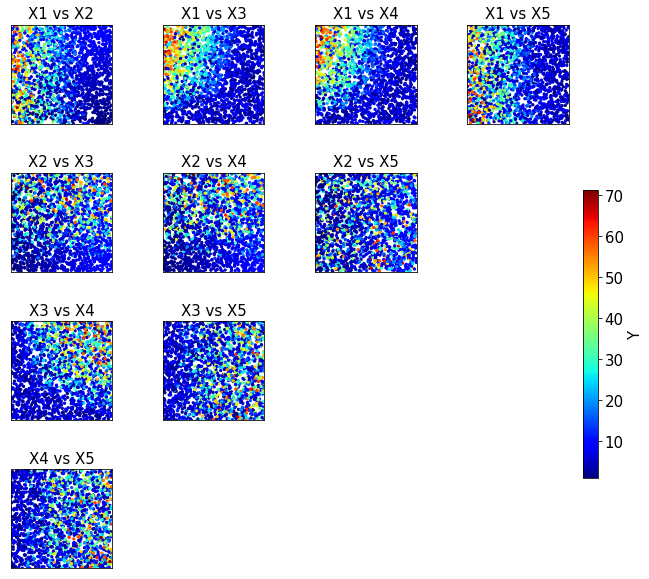

In [15]:
plt.rcParams['figure.figsize'] = [10, 10]
pf.scatter_plots_interaction(X, Y, ms=5)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, hspace=0.5, wspace=0.5)
plt.show()

### References

1. [SAFE Website](https://www.safetoolbox.info/)
2. [Introductory paper to SAFE - Pianosi et al. (2015)](https://www.sciencedirect.com/science/article/pii/S1364815215001188)
3. [PAWN method - Pianosi and Wagener (2018)](https://doi.org/10.1016/j.envsoft.2018.07.019)
4. [A review of available methods and workflows for Sensitivity Analysis - Pianosi et al. (2016)](https://www.sciencedirect.com/science/article/pii/S1364815216300287)
5. [What has Global Sensitivity Analysis ever done for us? A systematic review to support scientific advancement and to inform policy-making in earth system modelling - Wagener and Pianosi (2019)](https://www.sciencedirect.com/science/article/pii/S0012825218300990)
6. [Global Sensitivity Analysis . The primer - Saltelli et al. (2008)](http://www.andreasaltelli.eu/file/repository/A_Saltelli_Marco_Ratto_Terry_Andres_Francesca_Campolongo_Jessica_Cariboni_Debora_Gatelli_Michaela_Saisana_Stefano_Tarantola_Global_Sensitivity_Analysis_The_Primer_Wiley_Interscience_2008_.pdf) 
7. [Dummy parameter - Zadeh et al. (2017)](https://www.sciencedirect.com/science/article/pii/S1364815217301159)